# School Closure Intervention Example
This tutorial will walk through a simple example of adding school closures to an epydemix model. Note that the model must use population and contact matrices for a US location, i.e. a US state, the District of Columbia, or the total US. For simplicity we will work with an SIR model for the state of Massachussetts in this example.

In [1]:
from epydemix import load_predefined_model
from epydemix.population import load_epydemix_population
from epydemix.visualization import plot_quantiles

from flumodelingsuite.school_closures import make_school_closure_dict, add_school_closure_interventions

import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cm as cm

In [17]:
model = load_predefined_model("SIR")
model.add_parameter(parameter_name="transmission_rate", value=0.2)
population = load_epydemix_population("United_States_Massachusetts")
model.set_population(population)

print(model)
print(model.population)

EpiModel(name='EpiModel')
Compartments: 3
  Susceptible, Infected, Recovered
Transitions: 2
  Transitions between compartments:
    Susceptible -> Infected, params: ('transmission_rate', 'Infected') (kind: mediated)
    Infected -> Recovered, params: recovery_rate (kind: spontaneous)
Parameters: 2
  Model parameters:
    transmission_rate: 0.2
    recovery_rate: 0.1
Population: United_States_Massachusetts
  Population size: 7233476 individuals
  Demographic groups: 5
    0-4, 5-19, 20-49, 50-64, 65+

Population(name='United_States_Massachusetts')
Demographic groups: 5 groups
Population distribution:
  - 0-4: 420223 individuals
  - 5-19: 1349841 individuals
  - 20-49: 2986800 individuals
  - 50-64: 1479531 individuals
  - 65+: 997081 individuals
Contact matrices: 4 layers
Available layers:
  - school
  - work
  - home
  - community



The output shows our model structure:
- **Compartments:** Susceptible, Infected, and Recovered populations
- **Population:** 344+ million individuals across 5 age groups (0-4, 5-19, 20-49, 50-64, 65+)
- **Contact matrices:** Four interaction layers (school, work, home, community)

The age-structured approach is crucial because school closures primarily affect the 5-19 age group, and contact patterns vary significantly across age demographics.


## Generating School Closure Schedules

The next step involves creating a comprehensive database of school closures for 2024-2025. This process incorporates:
- **Regular academic calendars** (summer breaks, winter breaks, spring breaks)
- **National and state holidays** (holidays that affect school operations)
- **State-specific variations** (different states have different academic calendars)

In [3]:
closure_dict = make_school_closure_dict([2024, 2025])

Calculating closures from school calendars...

Merging school closures for total US model...

Finished iteration = 1. Progress to next iteration... 

Data reduction succesful! Stopped at iteration 2

Adding state and national holidays...

School closures computed.



The function automatically:
1. Calculates closure periods from school district calendars
2. Merges overlapping closure periods
3. Adds federal and state holidays

Let's examine the closure patterns for Massachusetts to understand what data we're working with:


In [18]:
closure_dict["MA"]

{Closure(start_date=datetime.date(2023, 12, 24), end_date=datetime.date(2024, 1, 4), name='Christmas Break'),
 Closure(start_date=datetime.date(2024, 1, 15), end_date=datetime.date(2024, 1, 15), name='Martin Luther King Jr. Day'),
 Closure(start_date=datetime.date(2024, 2, 15), end_date=datetime.date(2024, 2, 19), name='Mid Winter Break'),
 Closure(start_date=datetime.date(2024, 3, 17), end_date=datetime.date(2024, 3, 17), name='Evacuation Day'),
 Closure(start_date=datetime.date(2024, 3, 18), end_date=datetime.date(2024, 3, 18), name='Evacuation Day (observed)'),
 Closure(start_date=datetime.date(2024, 4, 15), end_date=datetime.date(2024, 4, 15), name="Patriots' Day"),
 Closure(start_date=datetime.date(2024, 4, 19), end_date=datetime.date(2024, 4, 23), name='Spring Break'),
 Closure(start_date=datetime.date(2024, 5, 27), end_date=datetime.date(2024, 5, 27), name='Memorial Day'),
 Closure(start_date=datetime.date(2024, 6, 18), end_date=datetime.date(2024, 9, 1), name='Summer Break'),
 

Each closure object contains:
- **start_date/end_date:** The temporal boundaries of the closure
- **name:** A descriptive label (e.g., "Summer Break", "Christmas Break")

Let's create a visualization to have a closer look

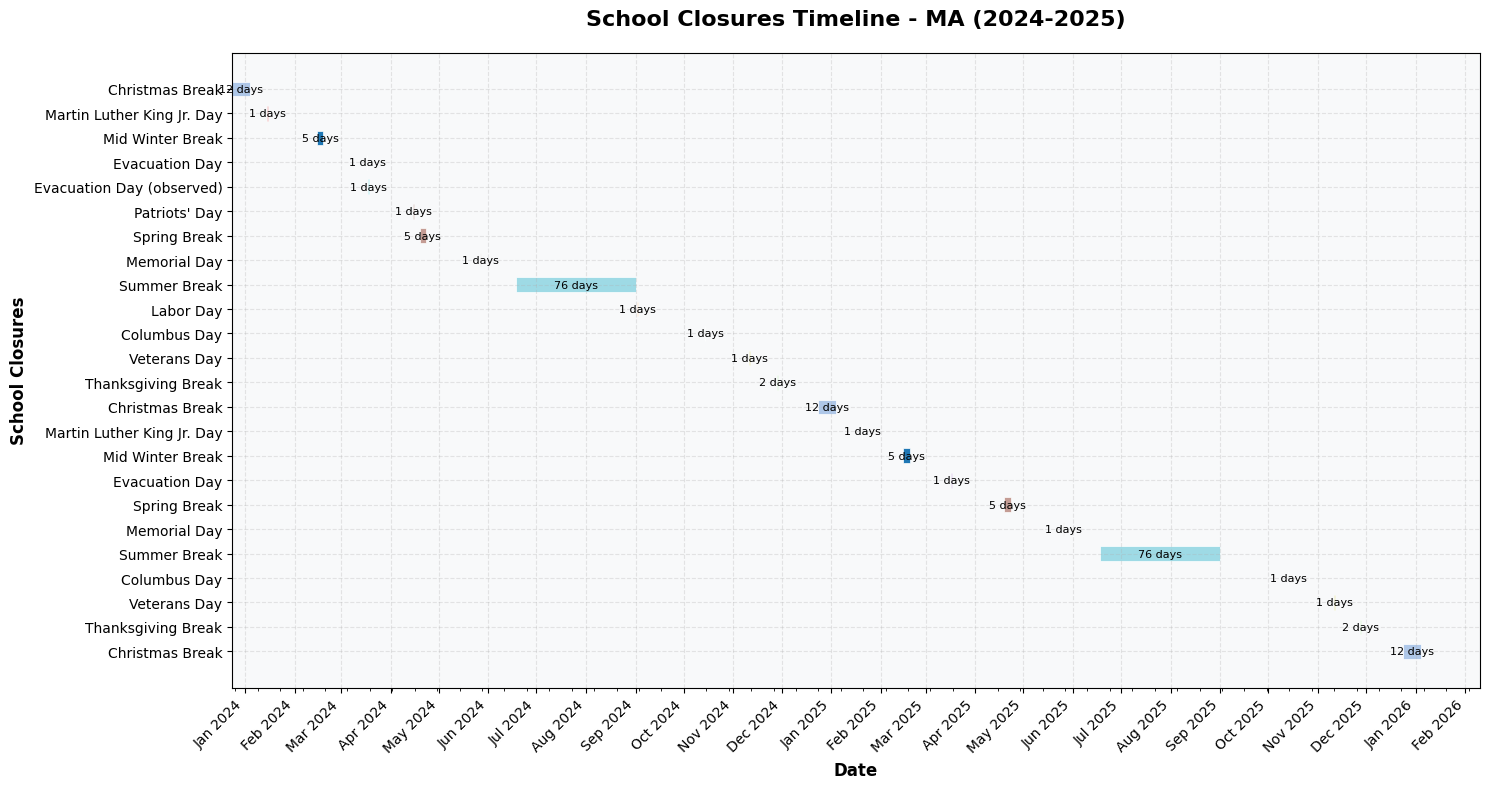


📊 Summary for MA:
Total closures: 24
Total closure days: 225
Longest closure: Summer Break (76 days)


In [23]:
state = "MA"
closures = closure_dict[state]

def visualize_school_closures(closures_dict, state='AK'):
    """
    Visualize school closures as a timeline with horizontal bars
    
    Parameters:
    closures_dict: dict with state as key and set of Closure objects as values
    state: state abbreviation to visualize
    """
    
    # Extract closures for the specified state
    closures = list(closures_dict.get(state, set()))
    
    if not closures:
        print(f"No closure data found for state: {state}")
        return
    
    # Sort closures by start date
    closures.sort(key=lambda x: x.start_date)
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(15, 8))
    
    # Define colors for different types of closures
    all_names = set()
    for state_closures in closures_dict.values():
        all_names.update(c.name for c in state_closures)

    # Create a color map for all unique names
    colors = cm.tab20(np.linspace(0, 1, len(all_names)))
    dynamic_color_map = dict(zip(all_names, colors))
    
    # Plot each closure as a horizontal bar
    y_positions = []
    labels = []
    
    for i, closure in enumerate(closures):
        # Convert dates to matplotlib date format
        start_date = mdates.date2num(closure.start_date)
        end_date = mdates.date2num(closure.end_date)
        
        # Calculate duration (add small amount for single-day events visibility)
        duration = max(end_date - start_date, 0.5)
        
        # Get color for this closure type
        color = dynamic_color_map.get(closure.name, '#95A5A6')
        
        # Plot horizontal bar
        ax.barh(i, duration, left=start_date, height=0.6, 
                color=color, alpha=1.0, edgecolor='white', linewidth=0.5)
        
        # Store position and label for y-axis
        y_positions.append(i)
        labels.append(closure.name)
        
        # Add duration text
        duration_days = (closure.end_date - closure.start_date).days + 1
        ax.text(start_date + duration/2, i, f'{duration_days} days', 
                ha='center', va='center', fontsize=8)
    
    # Customize the plot
    ax.set_yticks(y_positions)
    ax.set_yticklabels(labels, fontsize=10)
    ax.invert_yaxis()  # Put first closure at top
    
    # Format x-axis to show dates nicely
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    ax.xaxis.set_minor_locator(mdates.WeekdayLocator(interval=2))
    
    # Rotate date labels for better readability
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # Add grid for better readability
    ax.grid(True, alpha=0.3, linestyle='--')
    
    # Add title and labels
    ax.set_title(f'School Closures Timeline - {state} (2024-2025)', 
                fontsize=16, fontweight='bold', pad=20)
    ax.set_xlabel('Date', fontsize=12, fontweight='bold')
    ax.set_ylabel('School Closures', fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    
    # Add background color
    ax.set_facecolor('#F8F9FA')
    
    # Show the plot
    plt.show()
    
    # Print summary statistics
    print(f"\n📊 Summary for {state}:")
    print(f"Total closures: {len(closures)}")
    
    total_days = sum((c.end_date - c.start_date).days + 1 for c in closures)
    print(f"Total closure days: {total_days}")
    
    # Find longest closure
    longest = max(closures, key=lambda x: (x.end_date - x.start_date).days)
    longest_days = (longest.end_date - longest.start_date).days + 1
    print(f"Longest closure: {longest.name} ({longest_days} days)")

closures_by_state = {
    state: closures
}

# Create the visualization
visualize_school_closures(closures_by_state, state)


## Implementing School Closure Interventions

Now we integrate the closure schedule into our epidemiological model. The `add_school_closure_interventions` function modifies the contact matrices during closure periods by applying a reduction factor to school-based contacts. We need to provide the model, a closure dictionary and a reduction factor representing the proportional decrease in school contacts. Here we use `0.344` which corresponds to a 65.6% reduction in school contacts.


In [6]:
add_school_closure_interventions(model, closure_dict, 0.344)

School closure interventions added to model for United_States_California



School closure interventions added to model for United_States_Massachusetts

School closure interventions added to model for United_States_Massachusetts



Text(0.5, 1.0, 'CA')

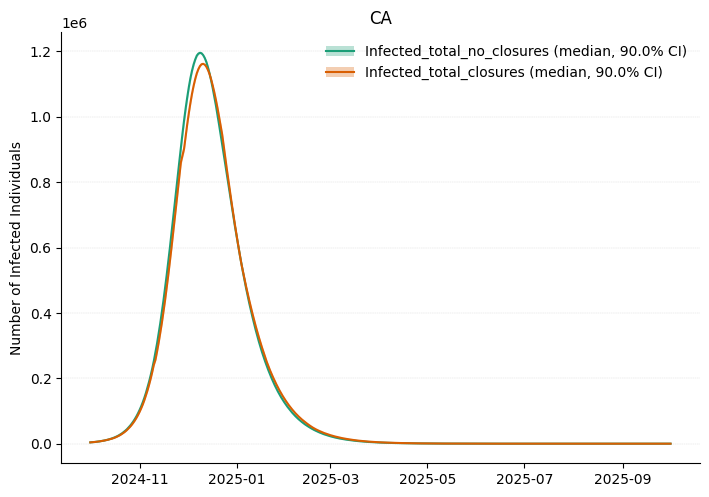

In [16]:
# Model configurations: (name, reduction_factor)
configs = [
    ("no_closures", 1.0), # No intervention (baseline)
    ("closures", 0.344)   # With school closures
]

# Run simulations for all configurations
results = {}
date_start = dt.date(2024, 10, 1)
date_stop = dt.date(2025, 10, 1)

for name, reduction in configs:
    model = load_predefined_model("SIR")
    model.add_parameter(parameter_name="transmission_rate", value=0.015)
    model.set_population(load_epydemix_population("United_States_Massachusetts"))
    add_school_closure_interventions(model, closure_dict, reduction)
    np.random.seed(19)
    results[name] = model.run_simulations(
        start_date=date_start, 
        end_date=date_stop,
        Nsim=25
    )

# Get quantiles and merge
dfs = {}
for name, result in results.items():
    df = result.get_quantiles_compartments()
    # Add suffix to all columns except merge keys
    for col in df.columns:
        if col not in ["date", "quantile"]:
            df = df.rename(columns={col: f"{col}_{name}"})
    dfs[name] = df

# Merge DataFrames
merged_df = dfs["no_closures"].merge(dfs["closures"], on=["date", "quantile"])

# Plot results
fig, ax = plt.subplots(figsize=(7, 5))
plot_quantiles(
    merged_df, 
    columns=["Infected_total_no_closures", "Infected_total_closures"], 
    legend_loc="upper right", 
    ax=ax
)
ax.set_ylabel("Number of Infected Individuals")
ax.set_title(state)

Here we can see that the inclusion of school closures can slow down the trajectory of an epidemic. The scenario with school closures has both a alightly lower peak of infectious individuals and the peak is delayed relative to the scenario without closures
